In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import scipy.stats as stats
import pandas as pd
import pickle
import os
from sklearn.linear_model import LinearRegression, Ridge

regions = {0: 'imgs', 1: 'caudate', 2: 'cerebellum', 3: 'frontal_lobe', 4: 'insula', 5: 'occipital_lobe', 6: 'parietal_lobe', 7: 'putamen', 8: 'temporal_lobe', 9: 'thalamus'}
root = '/media/leelabsg-storage1/yein/research/test/'
age_diff_groups = {}
disease_l = 'z864'
disease_u = 'Z864'

In [5]:
def bias_correction(true, pred):
    reg = LinearRegression().fit(true.reshape(-1, 1), pred)
    beta_0 = reg.intercept_
    beta_1 = reg.coef_[0]

    corrected_pred = (pred - beta_0) / beta_1
    return corrected_pred
    
def bias_correction_with_penalty(true, pred, alpha=1.0):
    true = np.array(true).reshape(-1, 1)
    pred = np.array(pred)
    
    # Ridge regression with regularization parameter alpha
    reg = Ridge(alpha=alpha).fit(true, pred)
    beta_0 = reg.intercept_
    beta_1 = reg.coef_[0]
    
    corrected_pred = (pred - beta_0) / beta_1
    
    return corrected_pred

def pickel_load_cn(root):

    map = dict()
    for _, v in regions.items():
        map[v] = {'pred_ages': [],
                 'true_ages': []}

    
    for cv_num in range(4):
        for content in ['pred_ages', 'true_ages']:
            pickel_path = os.path.join(root, str(cv_num), f'{content}.pickle')
            # print(pickel_path)
            with open(pickel_path, 'rb') as file:
                curr_cv = pickle.load(file) # cv-split size의 dict (region: age_lists)

            for _, v in regions.items():
                map[v][content].extend(curr_cv[v][0])

    # # bias corrected pred age
    # for region, age_list in map.items():
    #     print(region, len(map[region]['true_ages']), len(map[region]['pred_ages']))
    #     pred = np.array(map[region]['pred_ages'])
    #     true = np.array(map[region]['true_ages'])
    #     map[region]['corrected_pred_ages'] = bias_correction(true, pred)

    return map


def pickle_load(root):
    map = {v: {'pred_ages': [], 'true_ages': []} for _, v in regions.items()}

    # true_ages 4-cv model results gathering for averaging them
    for cv_num in range(4):
        pickel_path = os.path.join(root, str(cv_num), 'true_ages.pkl')
        if os.path.exists(pickel_path):
            with open(pickel_path, 'rb') as file:
                curr_cv = pickle.load(file)  # cv-split size의 dict (region: age_lists)  # age_lists length: 630
                for region, age_list in curr_cv.items():
                        map[region]['true_ages'] = age_list
    
    # pred_ages 4-cv model results gathering for averaging them
    for cv_num in range(4):
        pickle_path = os.path.join(root, str(cv_num), 'pred_ages.pkl')
        if os.path.exists(pickle_path):
            with open(pickle_path, 'rb') as file:
                curr_cv = pickle.load(file)
                for region, age_list in curr_cv.items():
                        map[region]['pred_ages'].append(age_list)
    # # 평균
    # if cn == False:
    #     for region, _ in map.items():
    #         map[region].setdefault('corrected_pred_ages', [])
    #         pred_ages_lists = map[region]['pred_ages']
    #         for pred in pred_ages_lists:
    #             true = map[region]['true_ages']
    #             # corrected_pred = bias_correction_with_penalty(true, pred, alpha)
    #             corrected_pred = bias_correction(np.array(true), np.array(pred))
    #             map[region]['corrected_pred_ages'].append(corrected_pred)
    #         pred_avg_age = [sum(values) / len(values) for values in zip(*pred_ages_lists)]
    #         map[region]['pred_ages'] = pred_avg_age

    #         corrected_pred_ages_lists = map[region]['corrected_pred_ages']
    #         corrected_pred_avg_age = [sum(values) / len(values) for values in zip(*corrected_pred_ages_lists)]
    #         map[region]['corrected_pred_ages'] = corrected_pred_avg_age

    #         print(region, len(map[region]['true_ages']), len(map[region]['pred_ages']), len(map[region]['corrected_pred_ages']))

    # else:
    #     for region, age_list in map.items():
    #         pred = np.array(map[region]['pred_ages'])
    #         true = np.array(map[region]['true_ages'])
    #         map[region]['corrected_pred_ages'] = bias_correction_with_penalty(true, pred, alpha)
    #         print(region, len(map[region]['true_ages']), len(map[region]['pred_ages']), len(map[region]['corrected_pred_ages']))

    
    for region, _ in map.items():
        pred_ages_lists = map[region]['pred_ages']
        pred_avg_age = [sum(values) / len(values) for values in zip(*pred_ages_lists)]
        map[region]['pred_ages'] = pred_avg_age

           
    # # bias corrected pred age
    # for region, age_list in map.items():
    #     print(region, len(map[region]['true_ages']), len(map[region]['pred_ages']))
    #     pred = np.array(map[region]['pred_ages'])
    #     true = np.array(map[region]['true_ages'])
    #     map[region]['corrected_pred_ages'] = bias_correction(true, pred)

    print("=" * 30)
    return map          

def age_dist_plot(region, cn, disease):
    plt.hist(cn[region]['true_ages'], bins=30, alpha=0.5, label='CN', density=True, edgecolor='black')
    plt.hist(disease[region]['true_ages'], bins=30, alpha=0.5, label='Disease', density=True, edgecolor='black')
    plt.title('Age Distribution by group')
    plt.xlabel('Age')
    plt.ylabel('Density')
    plt.legend(loc='upper right')
    plt.show()


def age_plot(data, region):
    true = data[region]['true_ages']
    pred = data[region]['pred_ages']
    if region == 'imgs':
        region = 'global'
    plt.figure(figsize=(7, 5))
    plt.scatter(true, pred, alpha=0.2)
    plt.plot([min(true), max(true)], [min(true), max(true)], color='red')  # y=x line
    plt.title(f'{region} ========== True Age and Predicted Age')
    plt.xlabel('True_Age')
    plt.ylabel('Predicted_Age')
    plt.show()

def age_plot_corrected(data, region):
    true = data[region]['true_ages']
    pred = data[region]['corrected_pred_ages']
    if region == 'imgs':
        region = 'global'
    plt.figure(figsize=(7, 5))
    plt.scatter(true, pred, alpha=0.2)
    plt.plot([min(true), max(true)], [min(true), max(true)], color='red')  # y=x line
    plt.title(f'{region} ========== True Age and Corrected Predicted Age')
    plt.xlabel('True_Age')
    plt.ylabel('Predicted_Age')
    plt.show()

def calculate_corrected_age_diff_avg(data, region):
    corrected_pred_ages = np.array(data[region]['corrected_pred_ages'])
    true_ages = np.array(data[region]['true_ages'])
    return np.mean(corrected_pred_ages - true_ages)

def age_diff_plot(age_diff_dict, regions):
    fig, ax = plt.subplots(figsize=(12, 8))

    age_diff_max = max(abs(max(age_diff_dict.values())), abs(min(age_diff_dict.values())))

    cmap = plt.get_cmap('coolwarm')
    norm = mcolors.Normalize(vmin=-age_diff_max, vmax=age_diff_max)

    for region, age_diff in age_diff_dict.items():
        color = cmap(norm(age_diff))
        ax.barh(region, age_diff, color=color)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('PAD (years)')

    ax.set_xlabel('Predicted Age Difference (years)')
    ax.set_title('Regional Predicted Age Difference (PAD)')
    plt.show()

# 예측 연령 차이 계산
def calculate_age_diff_avg(data, region):
    pred_ages = np.array(data[region]['pred_ages'])
    true_ages = np.array(data[region]['true_ages'])
    return np.mean(pred_ages - true_ages)

def calculate_age_diff_dist(data, region):
    corrected_pred_ages = np.array(data[region]['pred_ages'])
    true_ages = np.array(data[region]['true_ages'])
    diff = calculate_corrected_age_diff_avg(data, region)

    plt.hist(corrected_pred_ages, bins=30, alpha=0.5, label='Predicted', density=True, edgecolor='black', color='red')
    plt.hist(true_ages, bins=30, alpha=0.5, label='True', density=True, edgecolor='black', color='grey')
    # plt.hist(diff, bins=30, alpha=0.5, label='Difference', density=True, edgecolor='black')
    plt.title('Age Difference Distribution')
    plt.xlabel('Age Difference')
    plt.ylabel('Density')
    plt.legend(loc='upper right')
    plt.show()


def multi_group_age_diff_plot(age_diff_dict, groups, regions):
    fig, ax = plt.subplots(figsize=(12, 8))

    # 그룹별 색상 설정
    colors = {
        'CN': 'blue',
        'Disease': 'red'
    }

    bar_width = 0.2  # 막대의 너비
    index = np.arange(len(regions))  # 지역 인덱스

    # 각 그룹에 대해 PAD 값을 시각화
    for i, group in enumerate(groups):
        pad_values = [age_diff_groups[group][region] for region in regions]
        bar_positions = index + i * bar_width
        ax.barh(bar_positions, pad_values, bar_width, label=group, color=colors[group])

    ax.set_yticks(index + bar_width * (len(groups) - 1) / 2)
    ax.set_yticklabels(regions)
    ax.set_xlabel('Predicted Age Difference (years)')
    ax.set_title('Regional Predicted Age Difference (PAD) by Group')
    ax.legend()
    plt.show()

In [8]:
cn_root = root + 'ukb'
cn_ages = pickel_load_cn(cn_root)
disease_root = root + f'ukb_{disease_l}'
disease_ages = pickle_load(disease_root)
print(len(cn_ages['imgs']['true_ages']), len(disease_ages['imgs']['true_ages']))

25656 2231


In [ ]:
regions_name = list(regions.values())
regions_ages = dict()

for idx, region in enumerate(regions_name):
    print(region)
    ages = {
        'pred': [],
        'true': []
    }
    regions_ages.setdefault(region, ages)
    regions_ages[region]['pred'].extend(cn_ages[region]['pred_ages'])
    regions_ages[region]['true'].extend(cn_ages[region]['true_ages'])
    regions_ages[region]['pred'].extend(disease_root[region]['pred_ages'])

    true = np.array(regions_ages[region]['true'])
    pred = np.array(regions_ages[region]['pred'])
    regions_ages[region]['corrected_pred'] = bias_correction(true, pred)
    print(len(regions_ages[region]), len(regions_ages[region]['true']), len(regions_ages[region]['pred']), len(regions_ages[region]['corrected_pred']))

    cn_size = 25656
    disease_size = 2231
    adni_cn_ages[region]['corrected_pred_ages'] = adni_regions_ages[region]['corrected_pred'][:cn_size]
    adni_mci_ages[region]['corrected_pred_ages'] = adni_regions_ages[region]['corrected_pred'][cn_size :]

    print(len(adni_cn_ages[region]['corrected_pred_ages']), len(adni_mci_ages[region]['corrected_pred_ages']), len(adni_ad_ages[region]['corrected_pred_ages']))
    print("=" * 20)

# age distribution by group

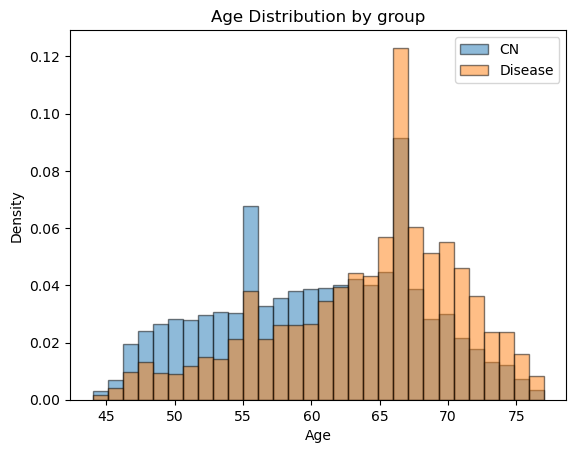

In [4]:
age_dist_plot('imgs', cn_ages, disease_ages)

In [5]:
def age_describe_group(group):
    df = pd.read_csv(f'/media/leelabsg-storage1/yein/research/BAE/RegionBAE/data/ukbb_{group}_region.csv')
    print(df['age'].describe())


age_describe_group('cn')
age_describe_group(disease_u)

count    25656.000000
mean        60.416004
std          7.382716
min         44.000000
25%         54.750000
50%         61.000000
75%         66.000000
max         77.000000
Name: age, dtype: float64
count    2231.000000
mean       63.990139
std         6.901933
min        44.000000
25%        60.000000
50%        65.000000
75%        69.000000
max        77.000000
Name: age, dtype: float64


# CN

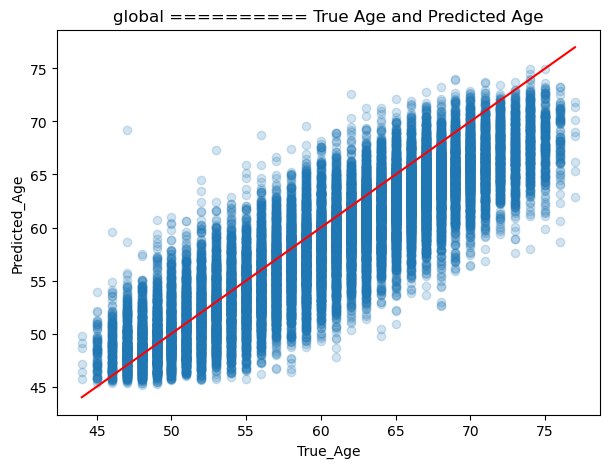

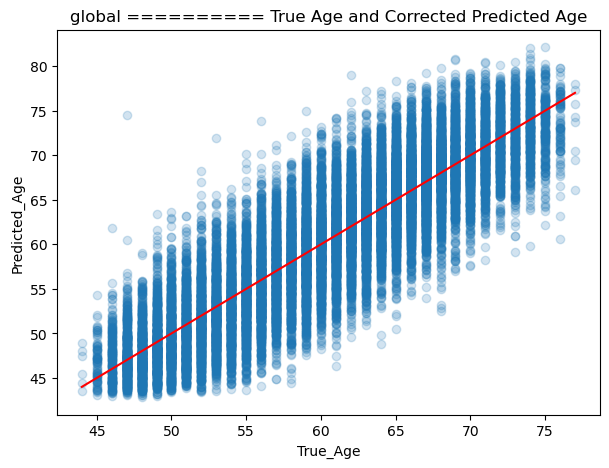

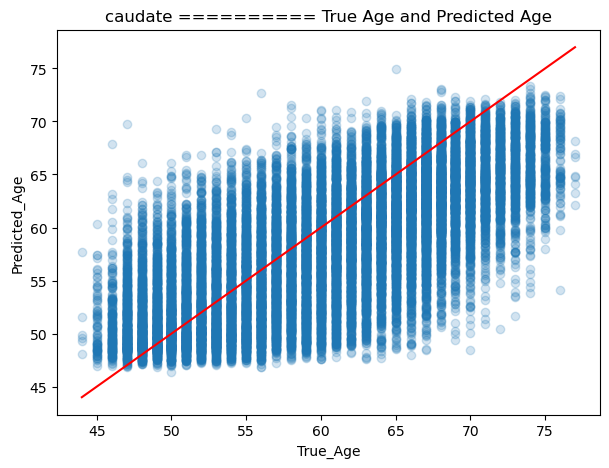

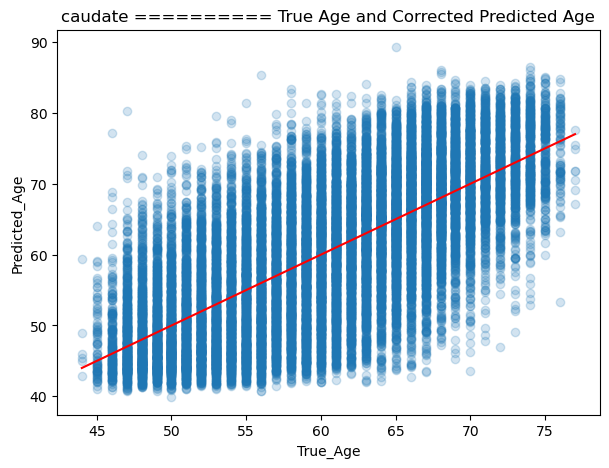

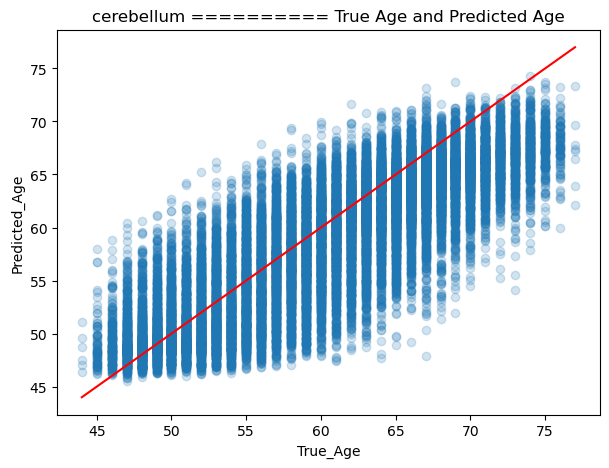

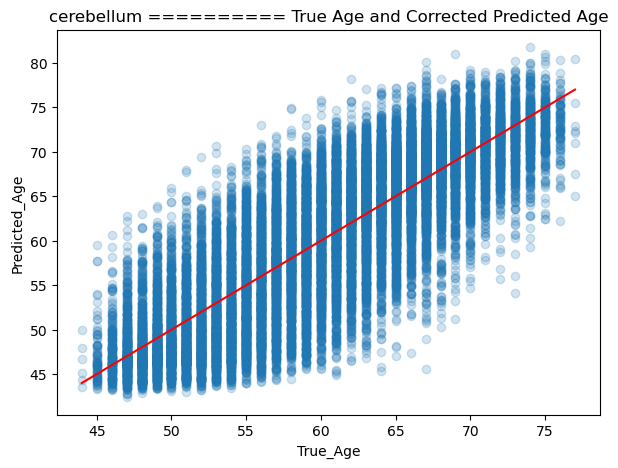

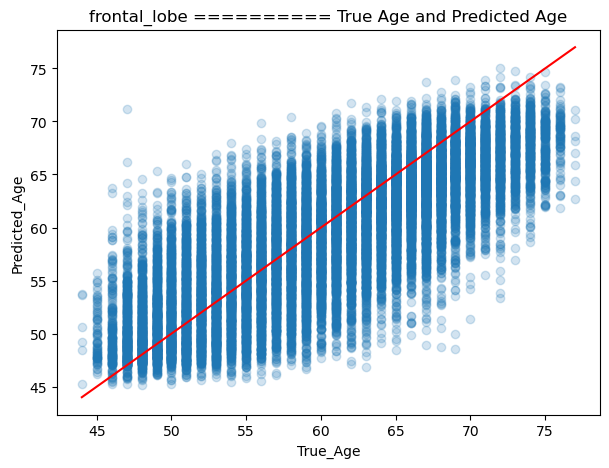

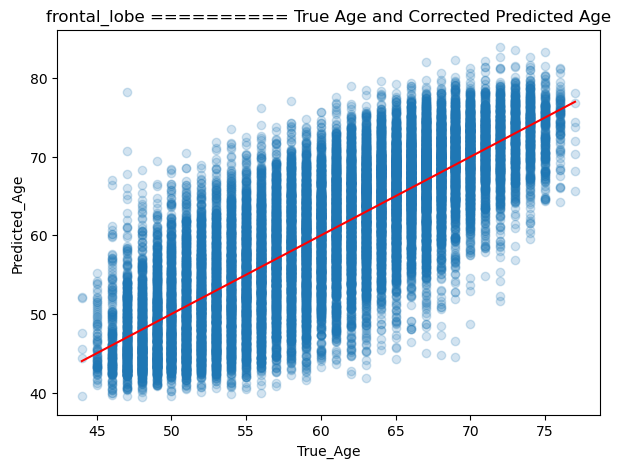

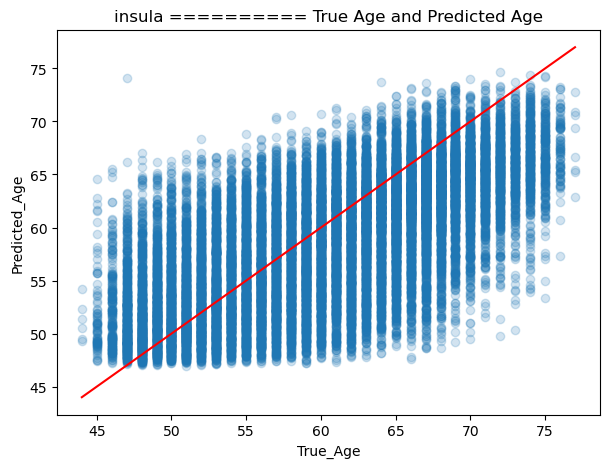

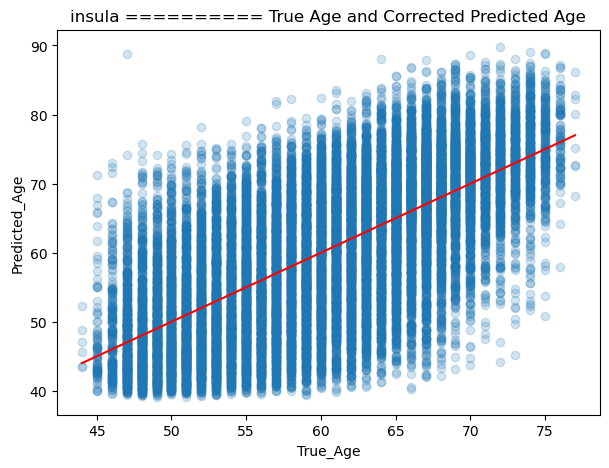

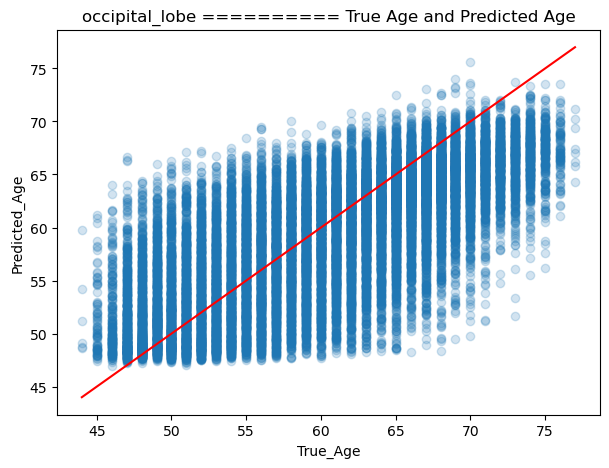

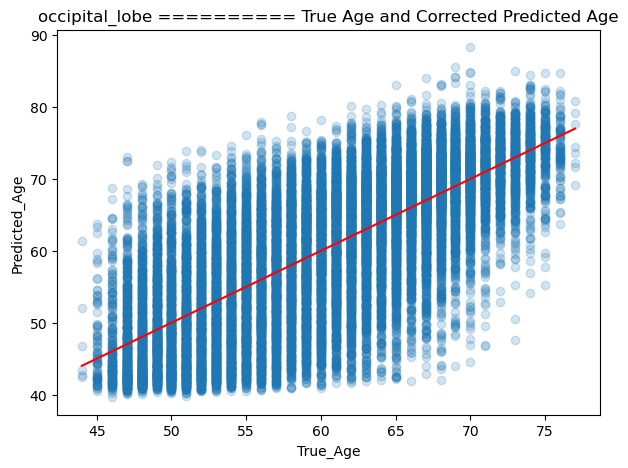

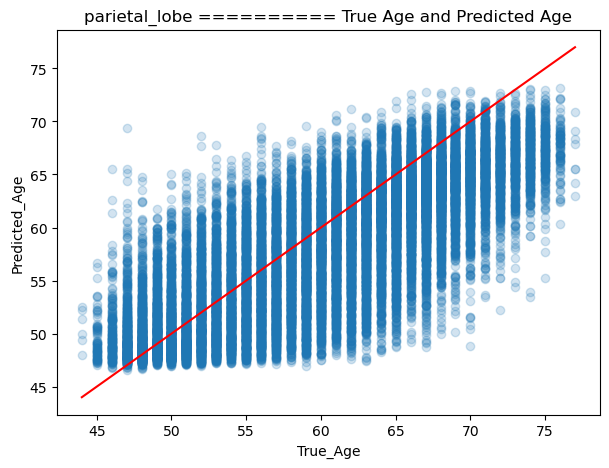

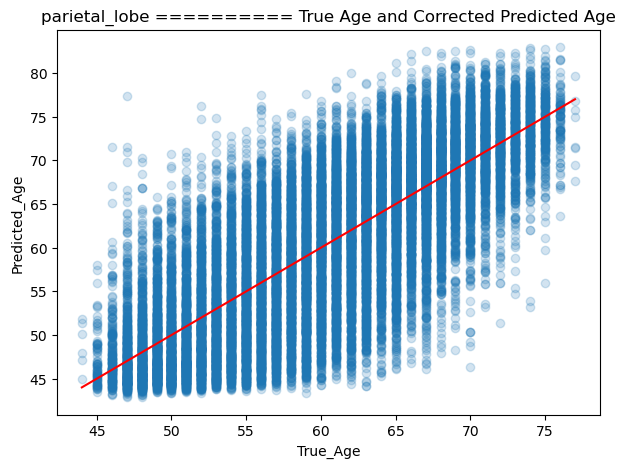

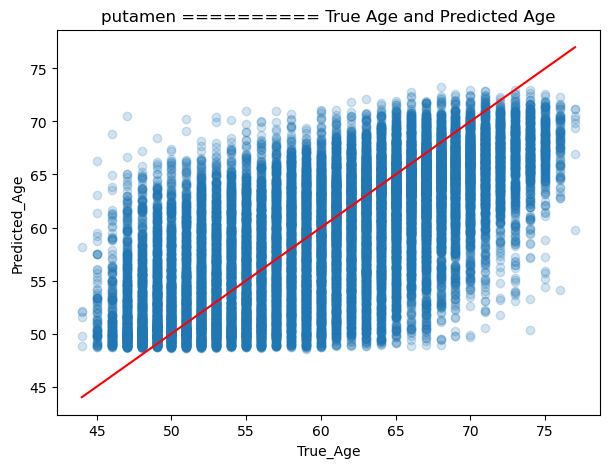

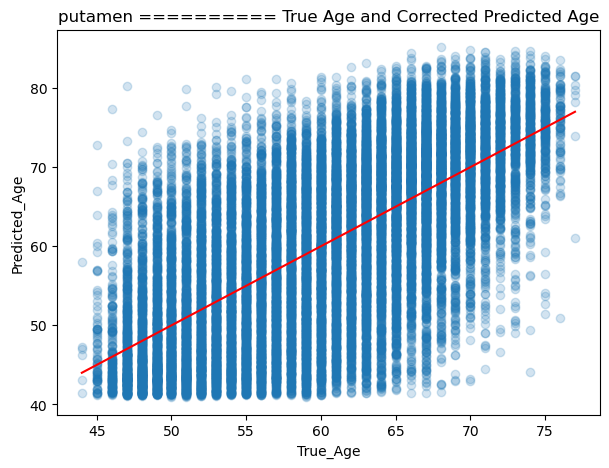

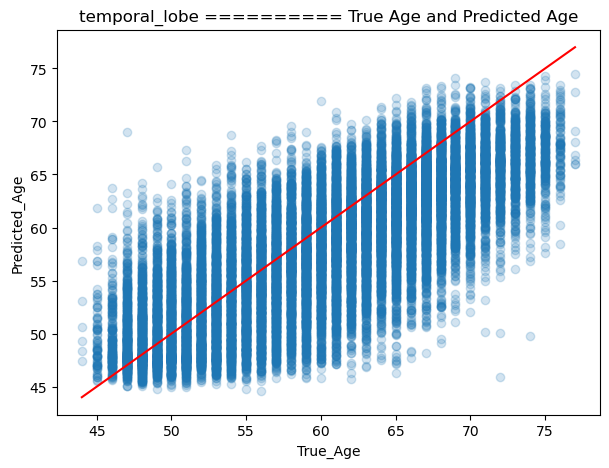

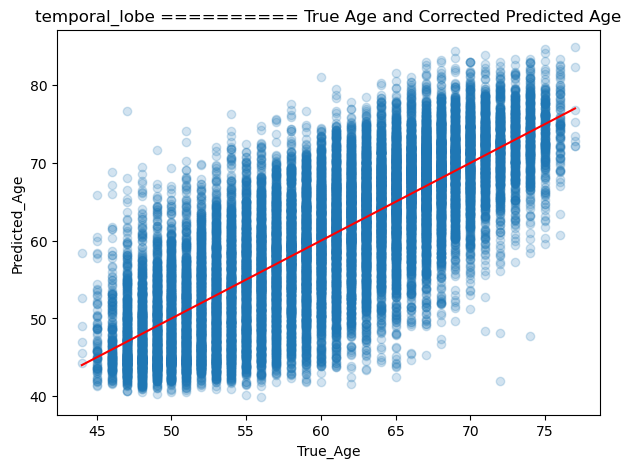

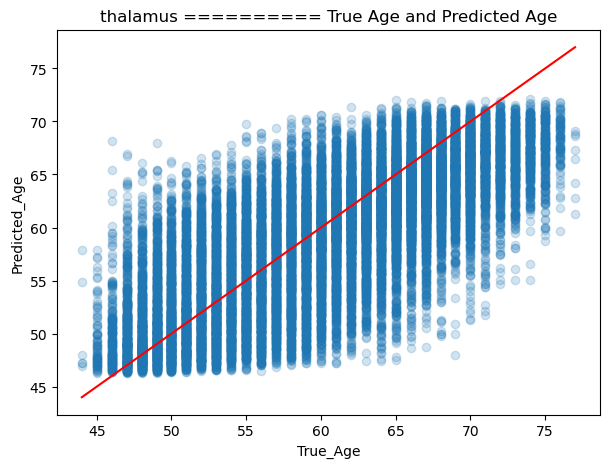

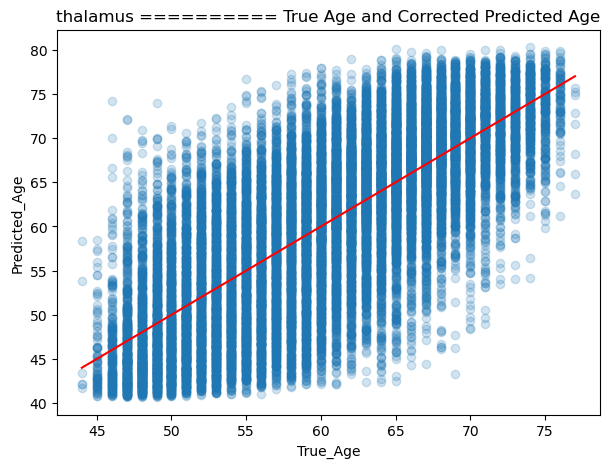

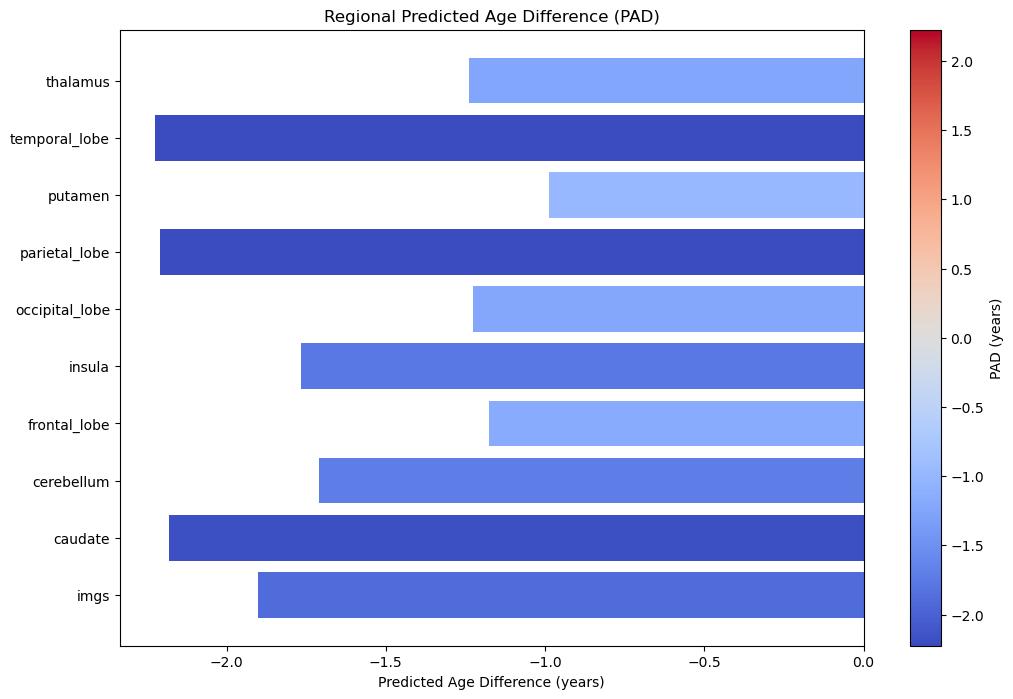

In [6]:
# 각 지역에 대한 예측 연령 차이 계산
age_diff_dict = {}
age_diff_groups['CN'] = dict()

for key, region in regions.items():
    age_plot(cn_ages, region)
    age_plot_corrected(cn_ages, region)
    age_diff_dict[region] = calculate_age_diff_avg(cn_ages, region)
    # age_diff_dict[region] = calculate_corrected_age_diff_avg(cn_ages, region)
    age_diff_groups['CN'][region] = age_diff_dict[region]

# 시각화
age_diff_plot(age_diff_dict, regions.values())

# Disease

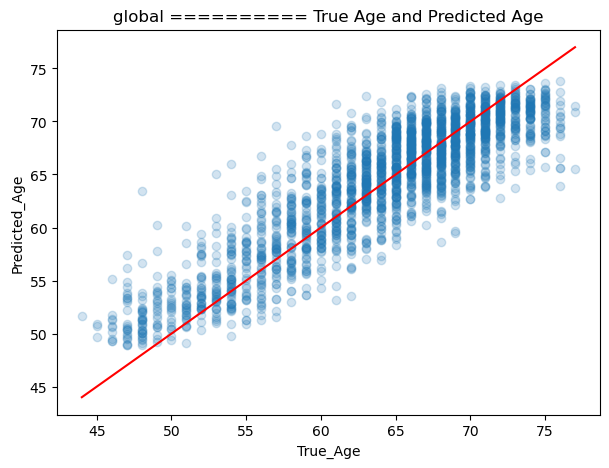

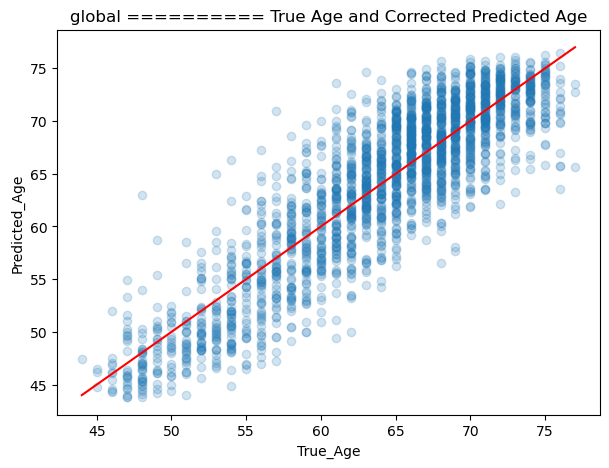

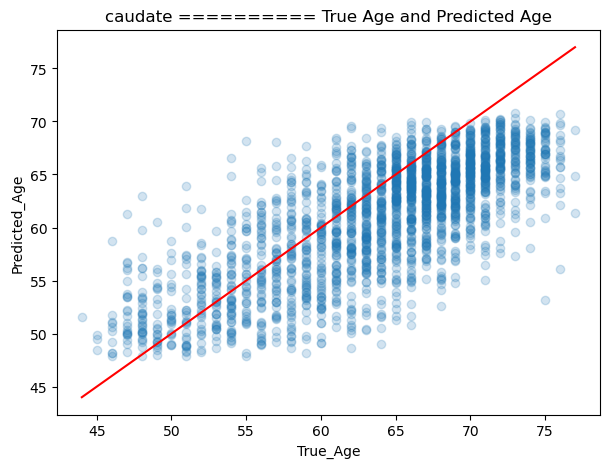

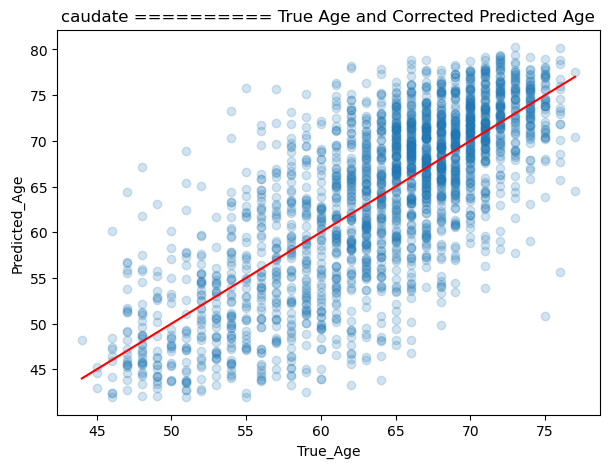

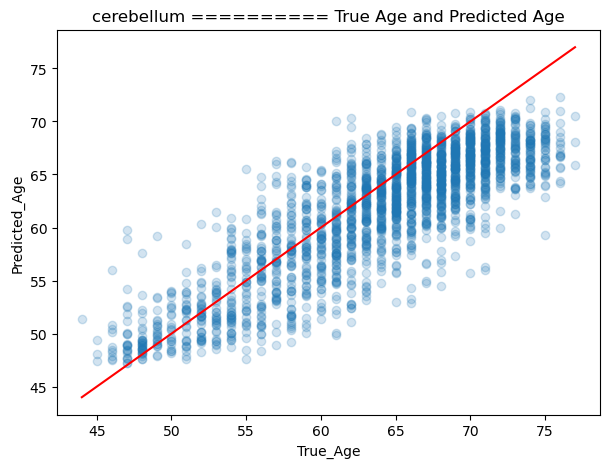

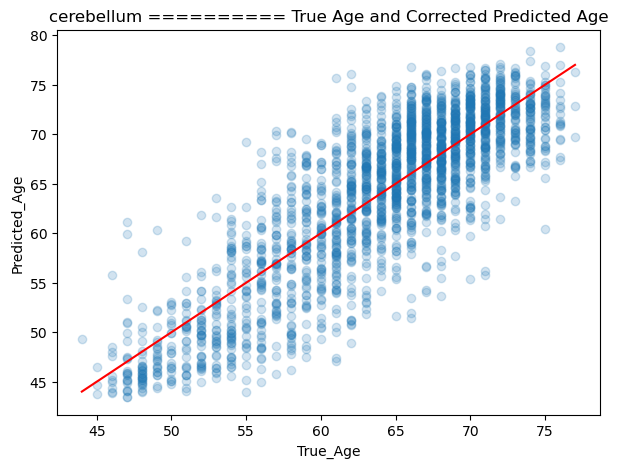

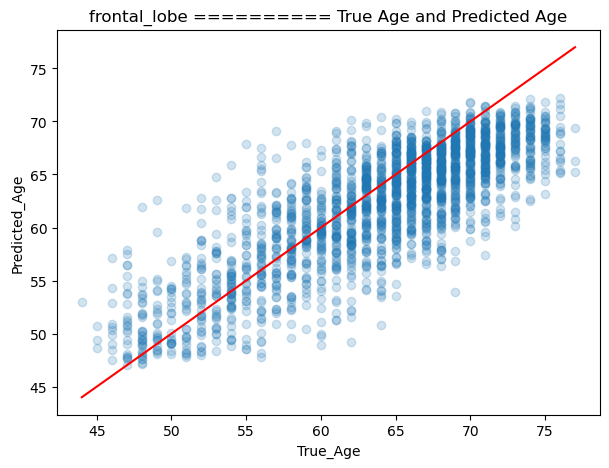

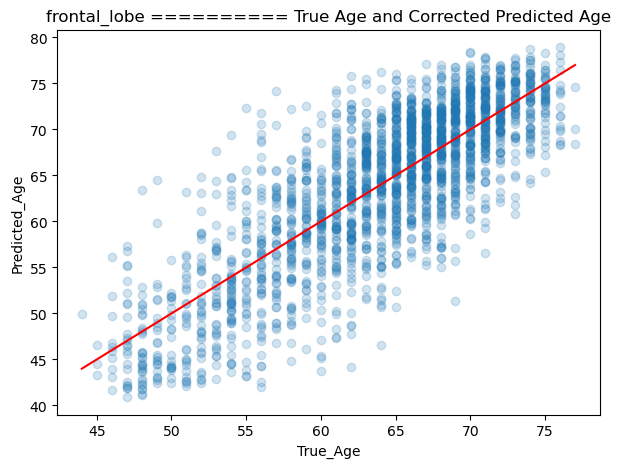

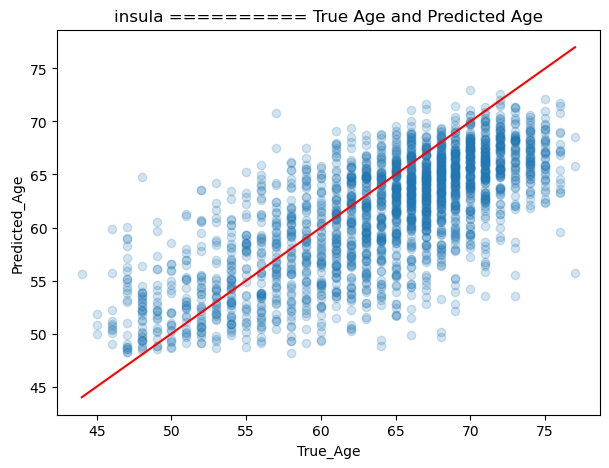

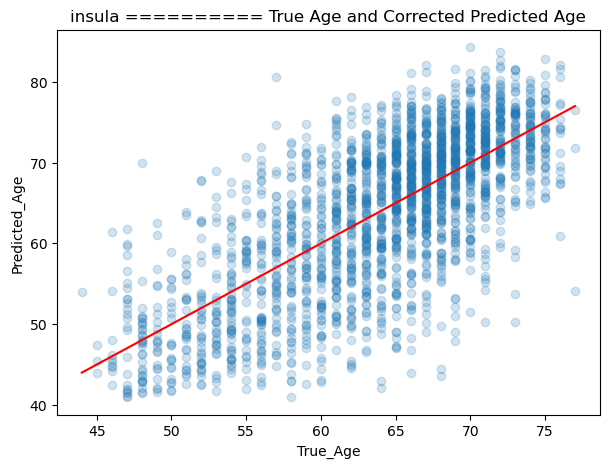

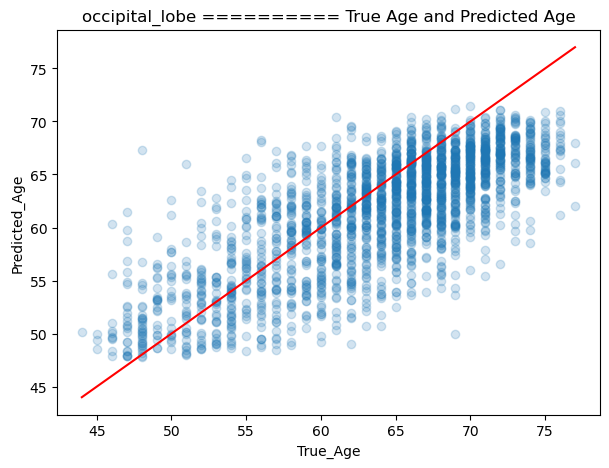

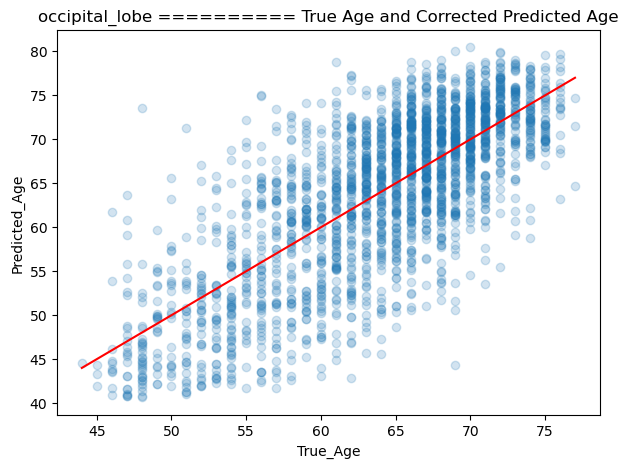

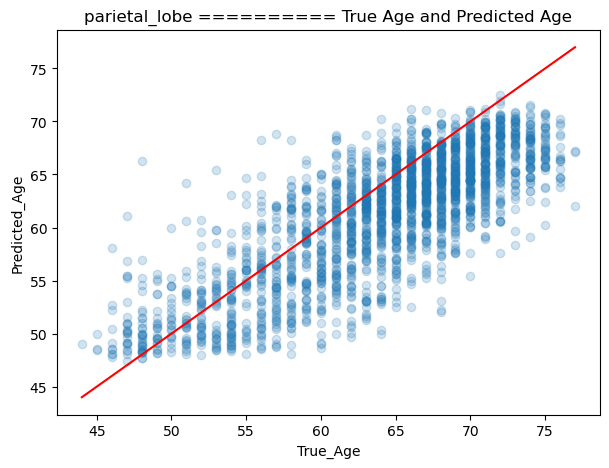

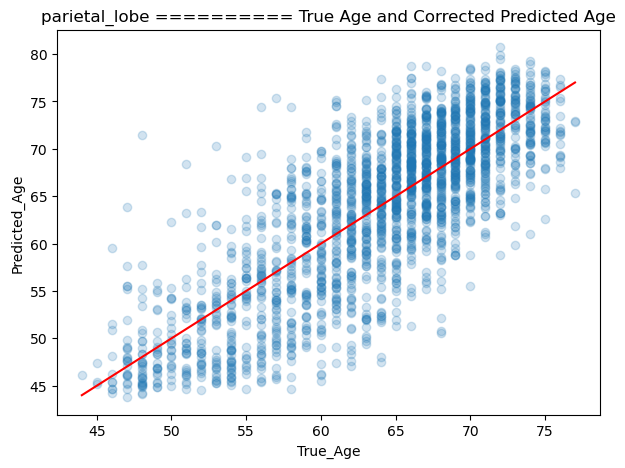

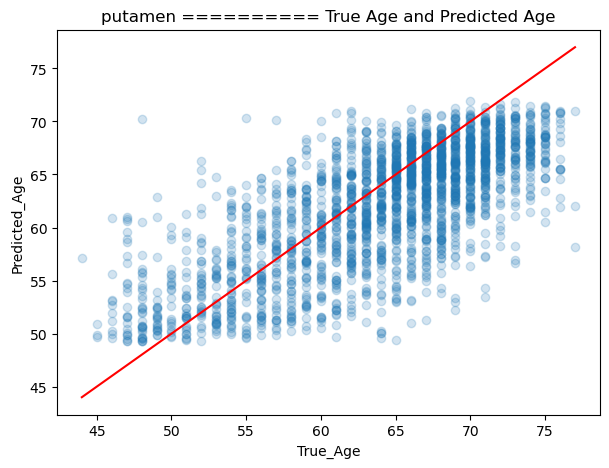

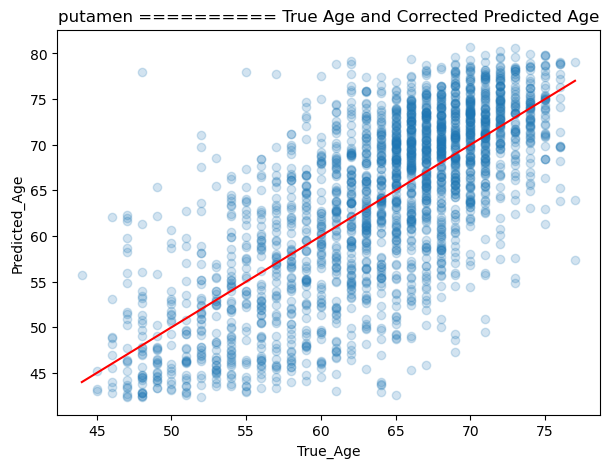

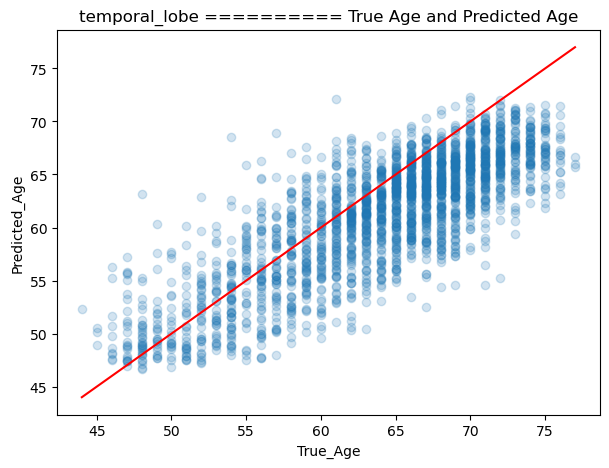

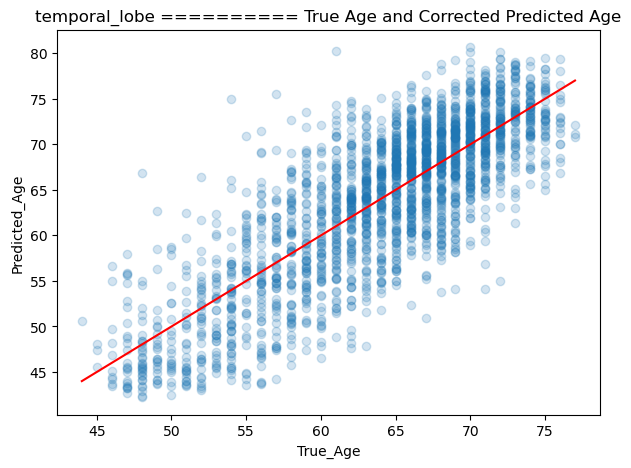

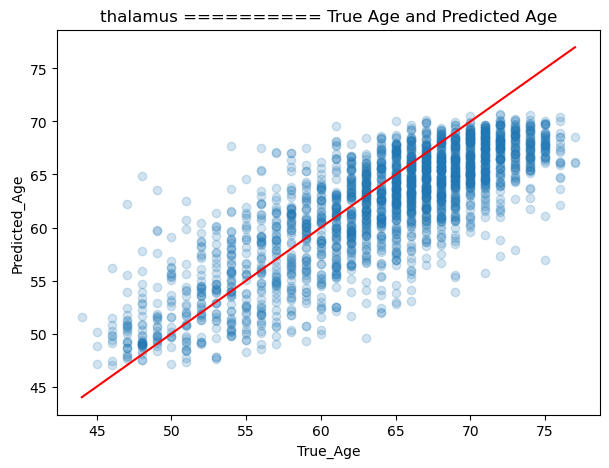

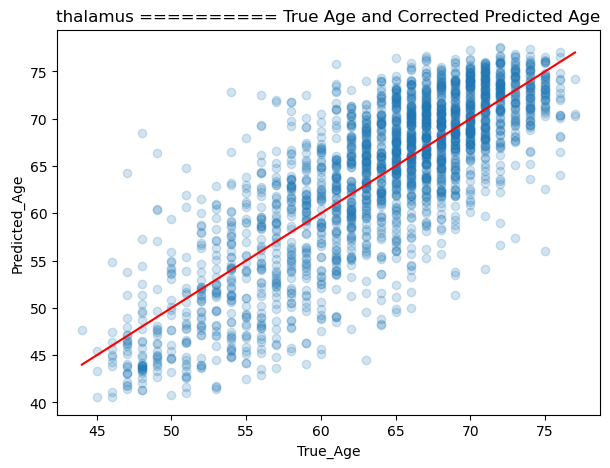

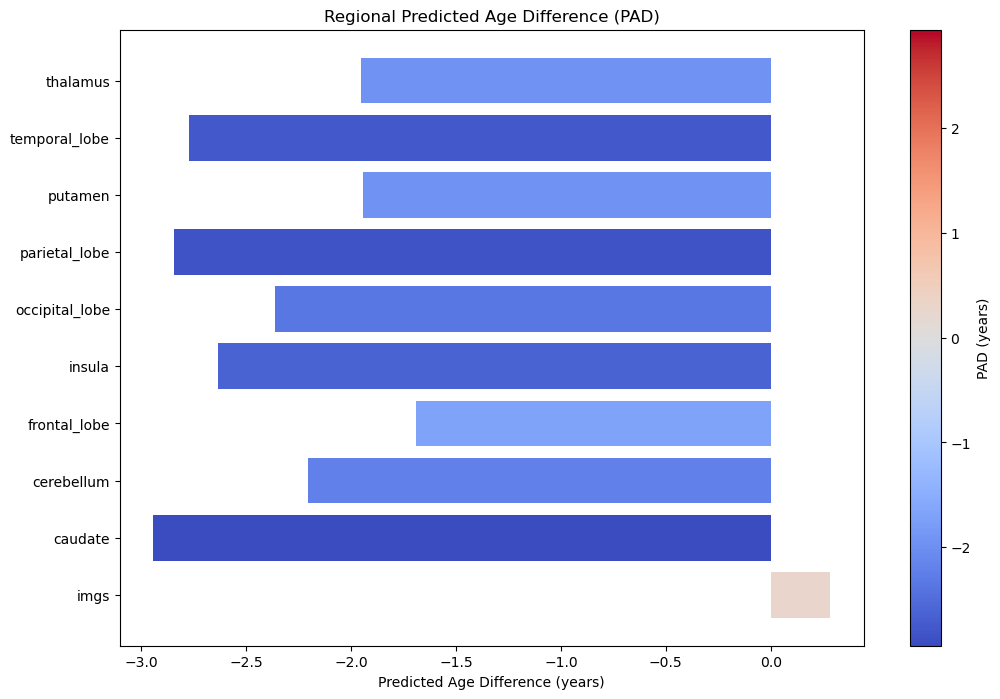

In [7]:
# 각 지역에 대한 예측 연령 차이 계산
age_diff_dict = {}
age_diff_groups['Disease'] = dict()

for key, region in regions.items():
    age_plot(disease_ages, region)
    age_plot_corrected(disease_ages, region)
    age_diff_dict[region] = calculate_age_diff_avg(disease_ages, region)
    # age_diff_dict[region] = calculate_corrected_age_diff_avg(disease_ages, region)
    age_diff_groups['Disease'][region] = age_diff_dict[region]

# 시각화
age_diff_plot(age_diff_dict, regions.values())

# Regional Predicted Age Difference (PAD) by Group

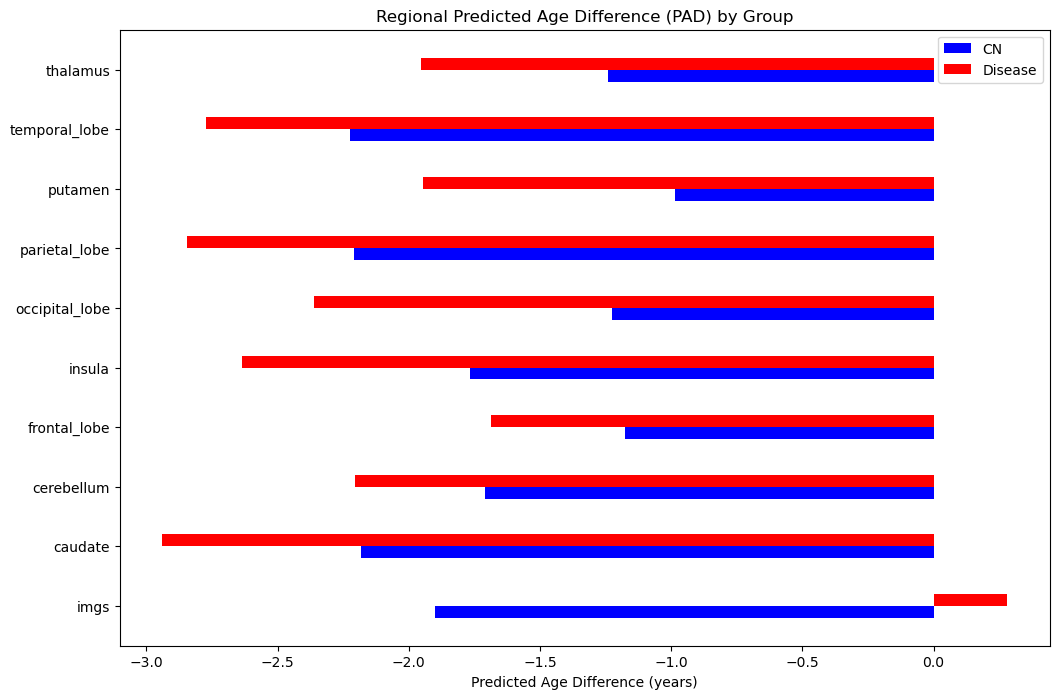

In [8]:
# 시각화
multi_group_age_diff_plot(age_diff_groups, ['CN', 'Disease'], regions.values())

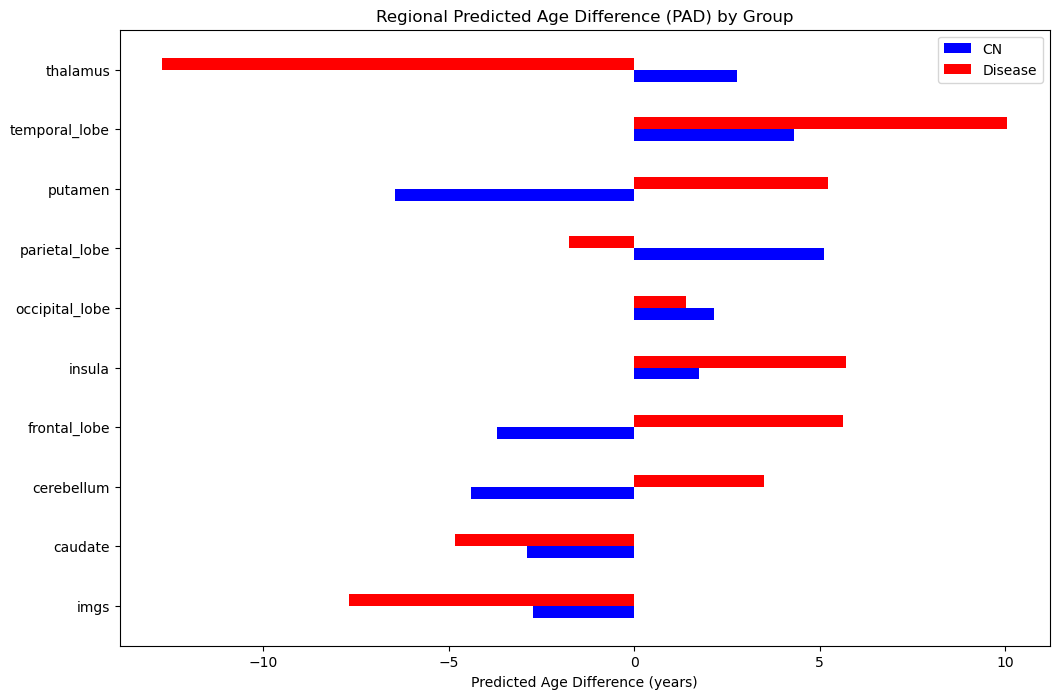

In [9]:
# 각 지역에 대한 예측 연령 차이 계산
age_diff_dict = {}
age_diff_groups['CN'] = dict()

for key, region in regions.items():
    age_diff_dict[region] = calculate_corrected_age_diff_avg(cn_ages, region)
    age_diff_groups['CN'][region] = age_diff_dict[region]
    
# 각 지역에 대한 예측 연령 차이 계산
age_diff_dict = {}
age_diff_groups['Disease'] = dict()

for key, region in regions.items():
    age_diff_dict[region] = calculate_corrected_age_diff_avg(disease_ages, region)
    age_diff_groups['Disease'][region] = age_diff_dict[region]


import numpy as np
import matplotlib.pyplot as plt

def multi_group_age_diff_plot_corrected(age_diff_dict, groups, regions):
    fig, ax = plt.subplots(figsize=(12, 8))

    # 그룹별 색상 설정
    colors = {
        'CN': 'blue',
        'Disease': 'red'
    }

    bar_width = 0.2  # 막대의 너비
    index = np.arange(len(regions))  # 지역 인덱스

    # 각 그룹에 대해 PAD 값을 시각화
    for i, group in enumerate(groups):
        pad_values = [age_diff_dict[group][region] for region in regions]
        
        # 스케일 조정 (예: 값을 1e6으로 나누어 단위를 적절하게 조정)
        pad_values = [val / 1e-6 for val in pad_values]
        
        bar_positions = index + i * bar_width
        ax.barh(bar_positions, pad_values, bar_width, label=group, color=colors[group])

    ax.set_yticks(index + bar_width * (len(groups) - 1) / 2)
    ax.set_yticklabels(regions)
    ax.set_xlabel('Predicted Age Difference (years)')
    ax.set_title('Regional Predicted Age Difference (PAD) by Group')
    ax.legend()
    plt.show()

multi_group_age_diff_plot_corrected(age_diff_groups, ['CN', 'Disease'], regions.values())

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 각 지역에 대한 예측 연령 차이 계산
age_diff_dict = {}
age_diff_groups['CN'] = dict()

for key, region in regions.items():
    age_diff_dict[region] = calculate_corrected_age_diff_avg(cn_ages, region)
    age_diff_groups['CN'][region] = age_diff_dict[region]
    
# 각 지역에 대한 예측 연령 차이 계산
age_diff_dict = {}
age_diff_groups['Disease'] = dict()

for key, region in regions.items():
    age_diff_dict[region] = calculate_corrected_age_diff_avg(disease_ages, region)
    age_diff_groups['Disease'][region] = age_diff_dict[region]

# 'CN' 그룹의 평균 차이 계산
cn_means = {region: np.mean([val for val in age_diff_groups['CN'].values()]) for region in age_diff_groups['CN'].keys()}

# 'CN' 그룹의 평균 차이를 다른 그룹의 값에 더하는 함수
def adjust_with_cn_mean(age_diff_dict, cn_means):
    adjusted_dict = {}
    for group, regions in age_diff_dict.items():
        adjusted_dict[group] = {region: val - cn_means[region] for region, val in regions.items()}
    return adjusted_dict

adjusted_age_diff_groups = adjust_with_cn_mean(age_diff_groups, cn_means)

def multi_group_age_diff_plot(age_diff_dict, groups, regions):
    fig, ax = plt.subplots(figsize=(14, 10))

    # 그룹별 색상 설정 (seaborn 팔레트 사용)
    colors = {
        'CN': '#2986cc',    # 정상군
        'Disease': '#cc0000'    # 치매군
    }

    bar_width = 0.3  # 막대의 너비
    index = np.arange(len(regions))  # 지역 인덱스

    # 각 그룹에 대해 PAD 값을 시각화
    for i, group in enumerate(groups):
        pad_values = [age_diff_dict[group][region] for region in regions]
        bar_positions = index + i * bar_width
        
        bars = ax.barh(bar_positions, pad_values, bar_width, label=group, color=colors[group], edgecolor='black')
        
        # 막대에 값 표시 (애너테이션)
        for bar in bars:
            width = bar.get_width()
            label_x_pos = width + 0.1 if width < 0 else width - 0.1
            ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}', 
                    va='center', ha='center', color='black', fontsize=12)

    # y축 정렬 및 스타일 설정
    ax.set_yticks(index + bar_width * (len(groups) - 1) / 2)
    ax.set_yticklabels(regions)
    ax.set_xlabel('Predicted Age Difference (years)', fontsize=12)
    ax.set_title('Regional Predicted Age Difference (PAD) by Group (Adjusted)', fontsize=16)
    ax.legend()
    
    # 그리드와 스타일 설정
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    sns.despine(left=True, bottom=True)
    
    # 레이아웃 조정
    fig.tight_layout()
    plt.show()



# 시각화
multi_group_age_diff_plot(adjusted_age_diff_groups, ['CN', 'Disease'], regions.values())

/tmp/ipykernel_97995/2563581657.py:71: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


ValueError: Image size of 8656593x860 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1400x1000 with 1 Axes>

{'CN': {'imgs': -2.7334495392277915, 'caudate': -2.883325398506628, 'cerebellum': -4.405873871582941, 'frontal_lobe': -3.706453119157146, 'insula': 1.750930957932809, 'occipital_lobe': 2.150599991800931, 'parietal_lobe': 5.119569275557382, 'putamen': -6.451798119378424, 'temporal_lobe': 4.3095260004339195, 'thalamus': 2.7786511033628756}, 'Disease': {'imgs': -7.682764022798802, 'caudate': -4.816140212589259, 'cerebellum': 3.510772032175162, 'frontal_lobe': 5.629231624905442, 'insula': 5.725020622357601, 'occipital_lobe': 1.387077866810973, 'parietal_lobe': -1.7448976322838805, 'putamen': 5.222914729327822, 'temporal_lobe': 10.06042797050966, 'thalamus': -12.728098234297484}}


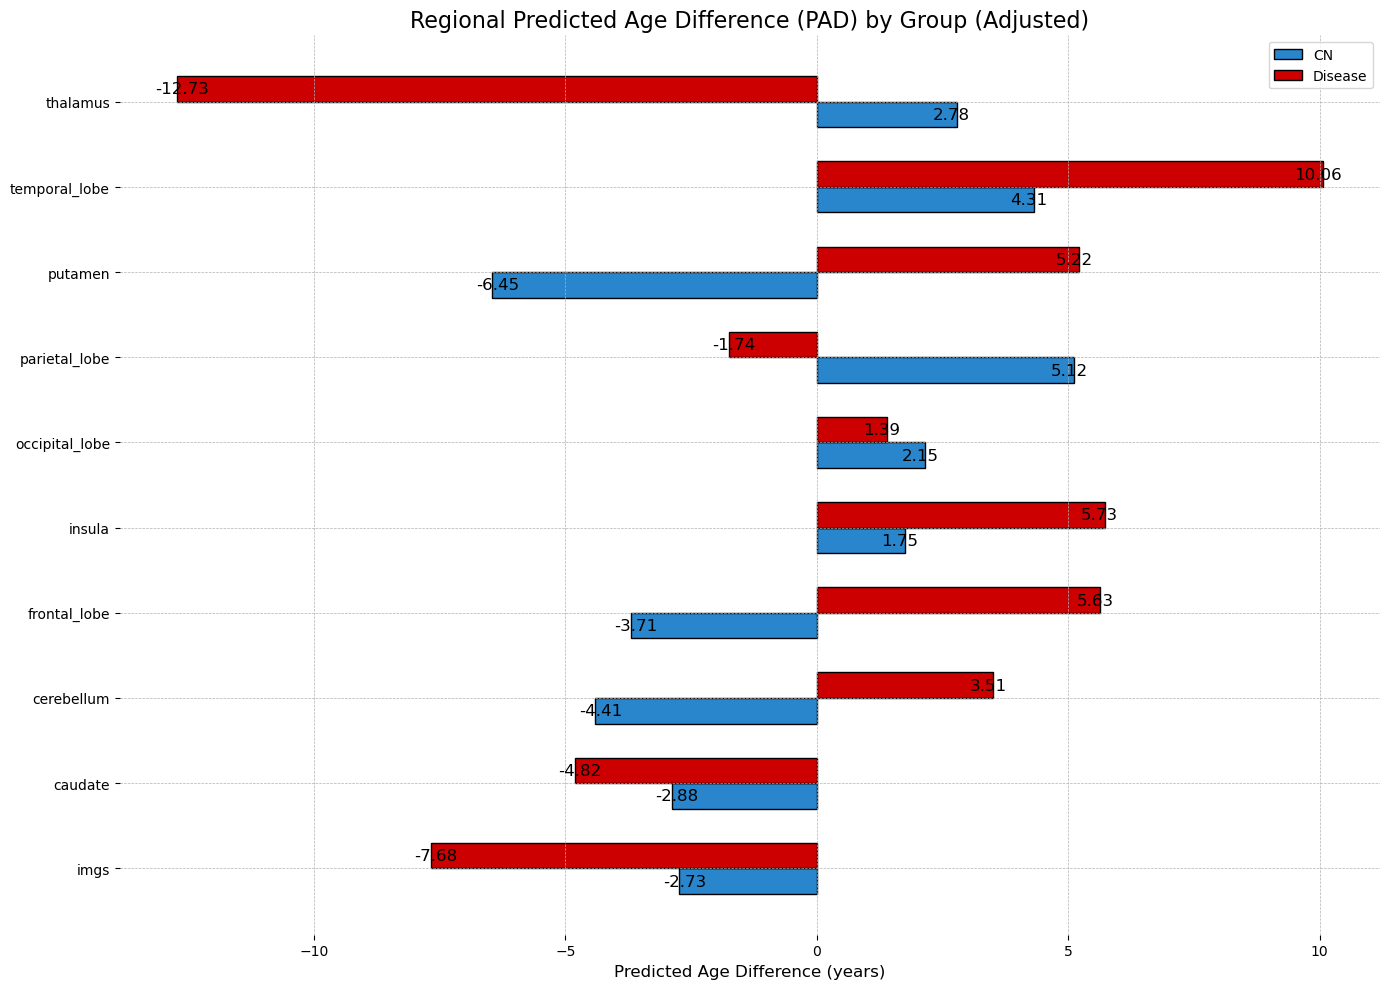

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 각 지역에 대한 예측 연령 차이 계산
age_diff_dict = {}
age_diff_groups['CN'] = dict()

for key, region in regions.items():
    age_diff_dict[region] = calculate_corrected_age_diff_avg(cn_ages, region)
    age_diff_groups['CN'][region] = age_diff_dict[region]
    
# 각 지역에 대한 예측 연령 차이 계산
age_diff_dict = {}
age_diff_groups['Disease'] = dict()

for key, region in regions.items():
    age_diff_dict[region] = calculate_corrected_age_diff_avg(disease_ages, region)
    age_diff_groups['Disease'][region] = age_diff_dict[region]

# 'CN' 그룹의 평균 차이 계산
cn_means = {region: np.mean([val for val in age_diff_groups['CN'].values()]) for region in age_diff_groups['CN'].keys()}

# 'CN' 그룹의 평균 차이를 다른 그룹의 값에 더하는 함수
def adjust_with_cn_mean(age_diff_dict, cn_means):
    adjusted_dict = {}
    for group, regions in age_diff_dict.items():
        adjusted_dict[group] = {region: val * 1000000 - cn_means[region] for region, val in regions.items()}
    return adjusted_dict

adjusted_age_diff_groups = adjust_with_cn_mean(age_diff_groups, cn_means)

def multi_group_age_diff_plot(age_diff_dict, groups, regions):
    print(age_diff_dict)
    fig, ax = plt.subplots(figsize=(14, 10))

    # 그룹별 색상 설정 (seaborn 팔레트 사용)
    colors = {
        'CN': '#2986cc',    # 정상군
        'Disease': '#cc0000'    # 치매군
    }

    bar_width = 0.3  # 막대의 너비
    index = np.arange(len(regions))  # 지역 인덱스

    # 각 그룹에 대해 PAD 값을 시각화
    for i, group in enumerate(groups):
        pad_values = [age_diff_dict[group][region] for region in regions]
        bar_positions = index + i * bar_width
        
        bars = ax.barh(bar_positions, pad_values, bar_width, label=group, color=colors[group], edgecolor='black')
        
        # 막대에 값 표시 (애너테이션)
        for bar in bars:
            width = bar.get_width()
            label_x_pos = width + 0.1 if width < 0 else width - 0.1
            ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}', 
                    va='center', ha='center', color='black', fontsize=12)

    # y축 정렬 및 스타일 설정
    ax.set_yticks(index + bar_width * (len(groups) - 1) / 2)
    ax.set_yticklabels(regions)
    ax.set_xlabel('Predicted Age Difference (years)', fontsize=12)
    ax.set_title('Regional Predicted Age Difference (PAD) by Group (Adjusted)', fontsize=16)
    ax.legend()
    
    # 그리드와 스타일 설정
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    sns.despine(left=True, bottom=True)
    
    # 레이아웃 조정
    fig.tight_layout()
    plt.show()



# 시각화
multi_group_age_diff_plot(adjusted_age_diff_groups, ['CN', 'Disease'], regions.values())

-1.6620276
{'CN': {'imgs': -0.2397368, 'caudate': -0.51887226, 'cerebellum': -0.047979474, 'frontal_lobe': 0.4860083, 'insula': -0.10454202, 'occipital_lobe': 0.43643796, 'parietal_lobe': -0.54616785, 'putamen': 0.67487663, 'temporal_lobe': -0.5627811, 'thalamus': 0.42275822}, 'Disease': {'imgs': 1.9427813170256503, 'caudate': -1.2786767700764696, 'cerebellum': -0.5441131161125932, 'frontal_lobe': -0.026356982308511245, 'insula': -0.9730800273224998, 'occipital_lobe': -0.6982983889893961, 'parietal_lobe': -1.1817049064319907, 'putamen': -0.28238989012704097, 'temporal_lobe': -1.1089497596786888, 'thalamus': -0.2916990817261085}}


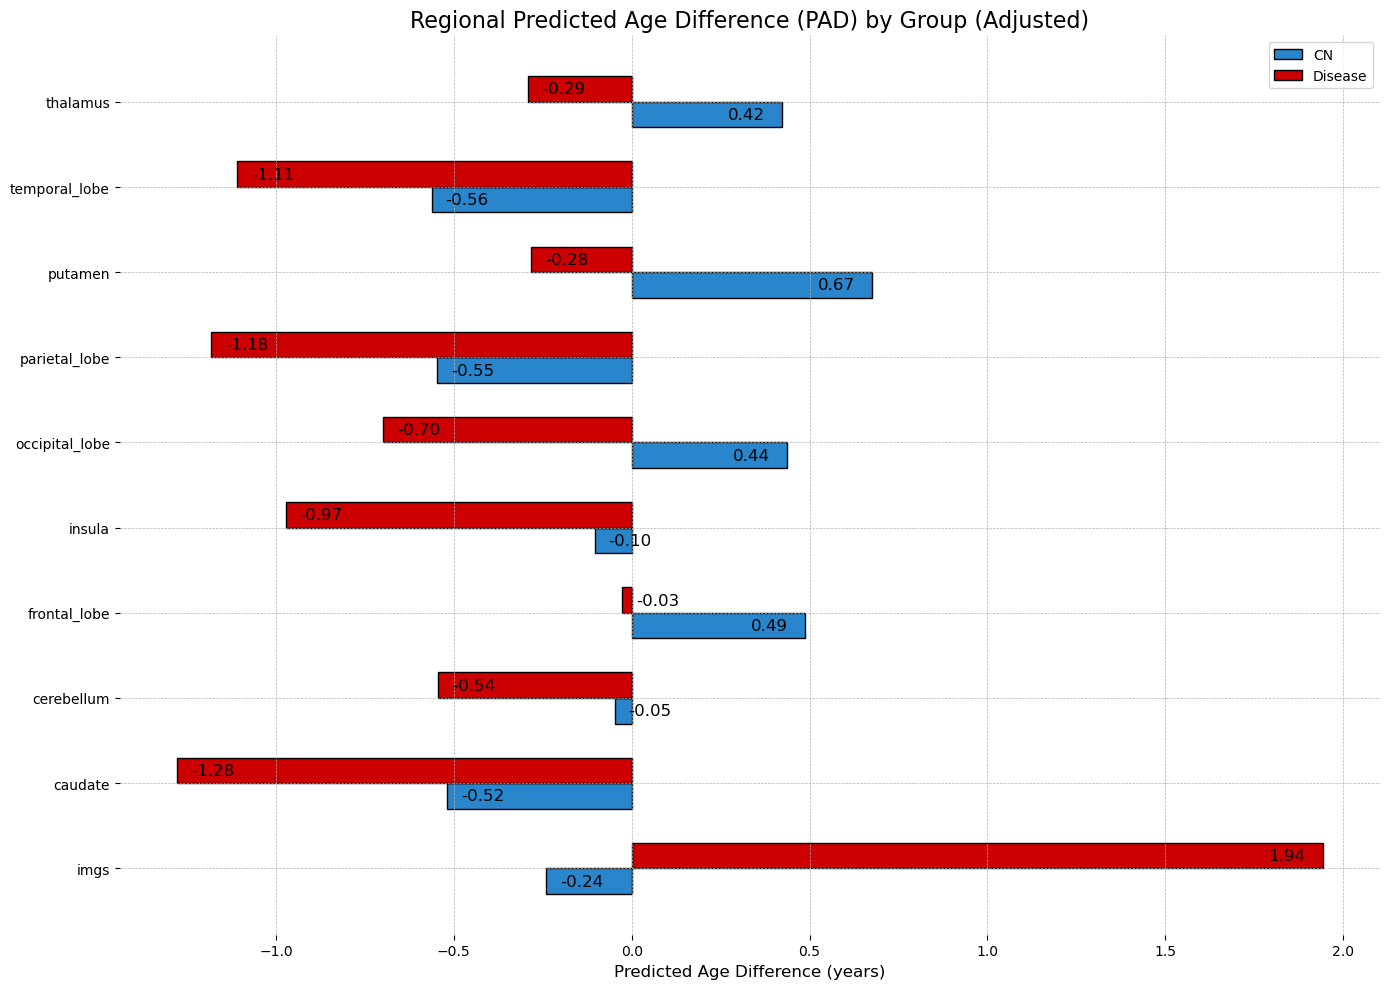

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 각 지역에 대한 예측 연령 차이 계산
age_diff_dict = {}
age_diff_groups['CN'] = dict()

for key, region in regions.items():
    age_diff_dict[region] = calculate_age_diff_avg(cn_ages, region)
    age_diff_groups['CN'][region] = age_diff_dict[region]
    
# 각 지역에 대한 예측 연령 차이 계산
age_diff_dict = {}
age_diff_groups['Disease'] = dict()

for key, region in regions.items():
    age_diff_dict[region] = calculate_age_diff_avg(disease_ages, region)
    age_diff_groups['Disease'][region] = age_diff_dict[region]

# 'CN' 그룹의 평균 차이 계산
cn_mean = np.mean([val for val in age_diff_groups['CN'].values()]) 
print(cn_mean)

# 'CN' 그룹의 평균 차이를 다른 그룹의 값에 더하는 함수
def adjust_with_cn_mean(age_diff_dict, cn_mean):
    adjusted_dict = {}
    for group, regions in age_diff_dict.items():
        adjusted_dict[group] = {region: val - cn_mean for region, val in regions.items()}
        # if group == 'CN':
        #     adjusted_dict[group] = regions
        # else:
        #     adjusted_dict[group] = {region: val - cn_means[region] for region, val in regions.items()}
    return adjusted_dict


adjusted_age_diff_groups = adjust_with_cn_mean(age_diff_groups, cn_mean)

def multi_group_age_diff_plot(age_diff_dict, groups, regions):
    print(age_diff_dict)
    fig, ax = plt.subplots(figsize=(14, 10))

    # 그룹별 색상 설정 (seaborn 팔레트 사용)
    colors = {
        'CN': '#2986cc',    # 정상군
        'Disease': '#cc0000'    # 치매군
    }

    bar_width = 0.3  # 막대의 너비
    index = np.arange(len(regions))  # 지역 인덱스

    # 각 그룹에 대해 PAD 값을 시각화
    for i, group in enumerate(groups):
        pad_values = [age_diff_dict[group][region] for region in regions]
        bar_positions = index + i * bar_width
        
        bars = ax.barh(bar_positions, pad_values, bar_width, label=group, color=colors[group], edgecolor='black')
        
        # 막대에 값 표시 (애너테이션)
        for bar in bars:
            width = bar.get_width()
            label_x_pos = width + 0.1 if width < 0 else width - 0.1
            ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}', 
                    va='center', ha='center', color='black', fontsize=12)

    # y축 정렬 및 스타일 설정
    ax.set_yticks(index + bar_width * (len(groups) - 1) / 2)
    ax.set_yticklabels(regions)
    ax.set_xlabel('Predicted Age Difference (years)', fontsize=12)
    ax.set_title('Regional Predicted Age Difference (PAD) by Group (Adjusted)', fontsize=16)
    ax.legend()
    
    # 그리드와 스타일 설정
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    sns.despine(left=True, bottom=True)
    
    # 레이아웃 조정
    fig.tight_layout()
    plt.show()



# 시각화
multi_group_age_diff_plot(adjusted_age_diff_groups, ['CN', 'Disease'], regions.values())

In [44]:
age_diff_groups['CN']

{'imgs': -1.9017644,
 'caudate': -2.1808999,
 'cerebellum': -1.7100071,
 'frontal_lobe': -1.1760193,
 'insula': -1.7665696,
 'occipital_lobe': -1.2255896,
 'parietal_lobe': -2.2081954,
 'putamen': -0.98715097,
 'temporal_lobe': -2.2248087,
 'thalamus': -1.2392694}

In [45]:
age_diff_groups['Disease']

{'imgs': -7.682764429961475e-06,
 'caudate': -4.816140619751932e-06,
 'cerebellum': 3.5107716250124884e-06,
 'frontal_lobe': 5.6292312177427686e-06,
 'insula': 5.725020215194927e-06,
 'occipital_lobe': 1.3870774596482994e-06,
 'parietal_lobe': -1.7448980394465539e-06,
 'putamen': 5.222914322165149e-06,
 'temporal_lobe': 1.0060427563346988e-05,
 'thalamus': -1.2728098641460157e-05}

# Age Difference Distribution

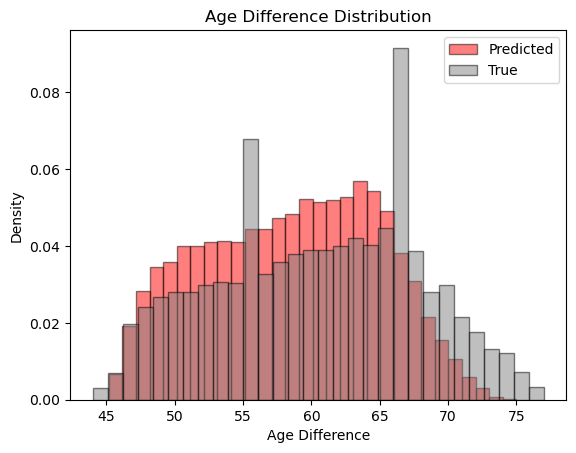

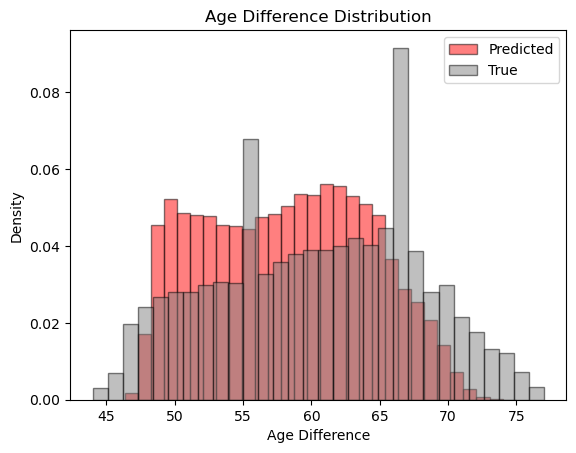

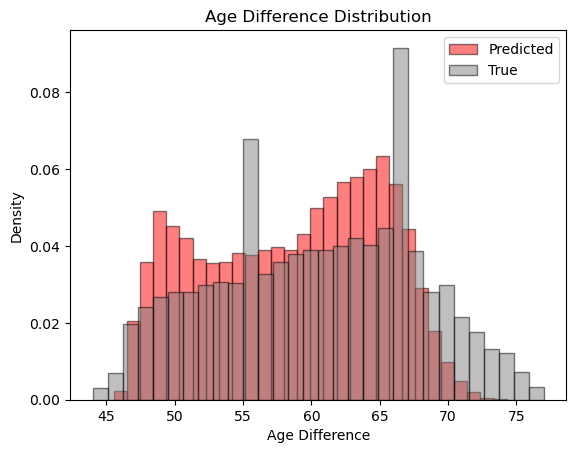

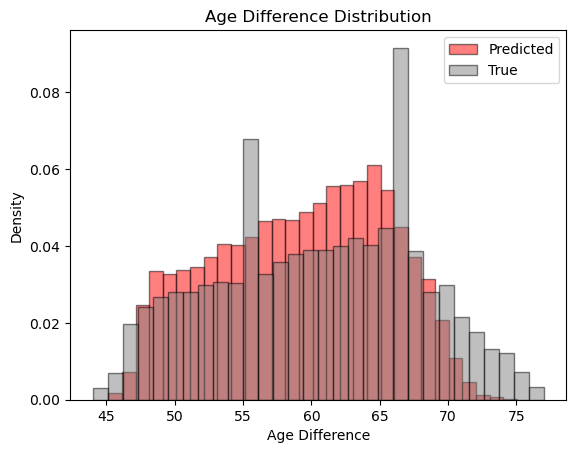

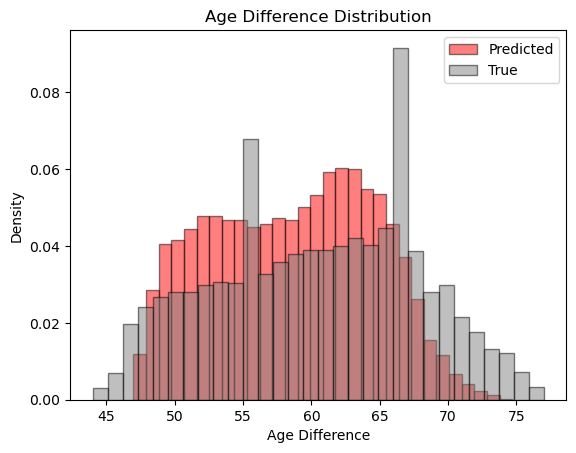

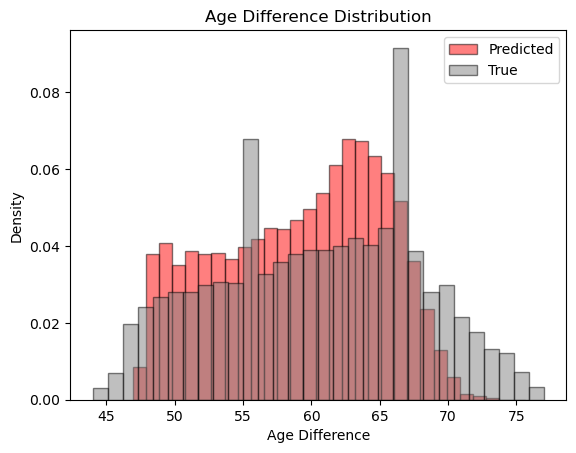

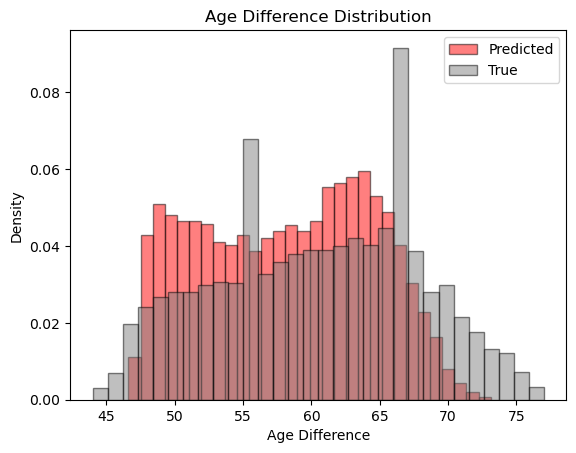

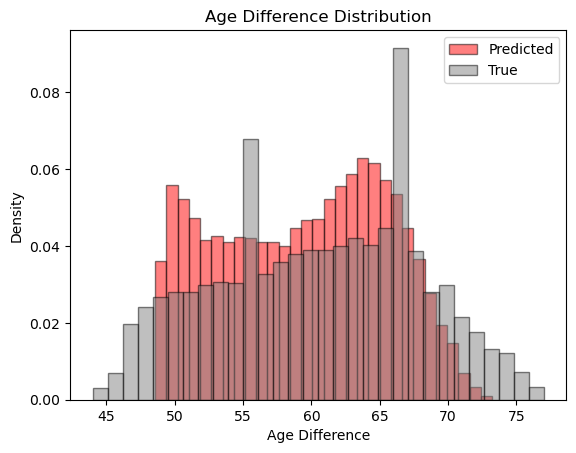

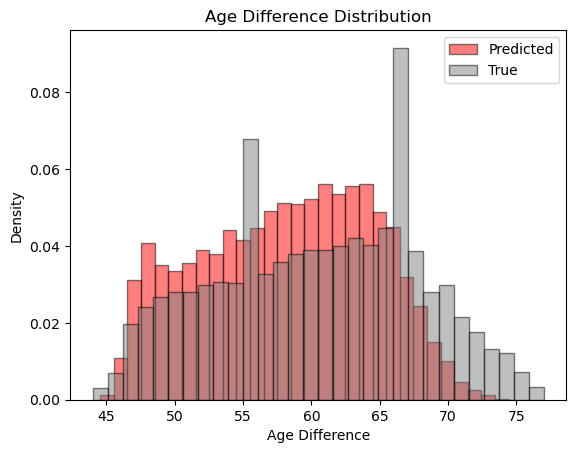

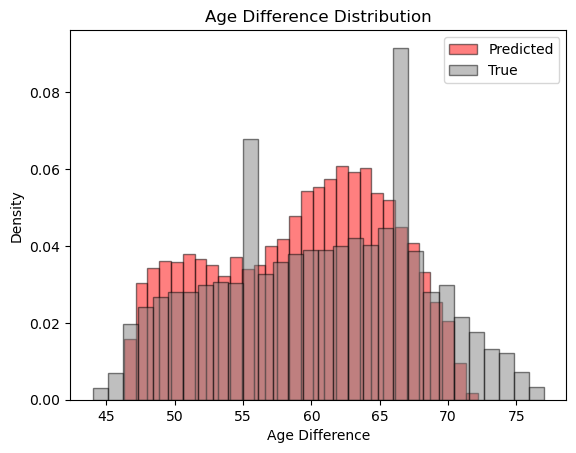

In [28]:
for key, region in regions.items():
    calculate_age_diff_dist(cn_ages,region)

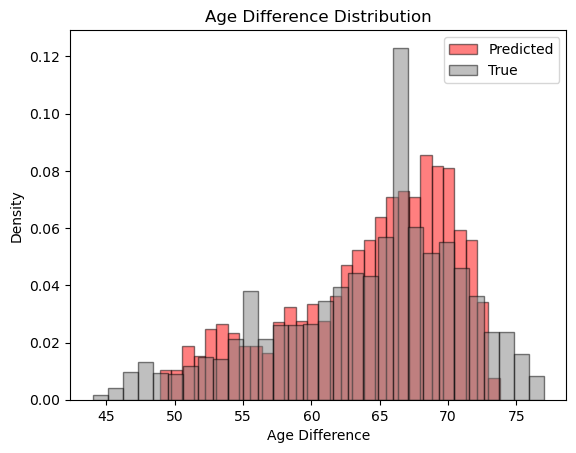

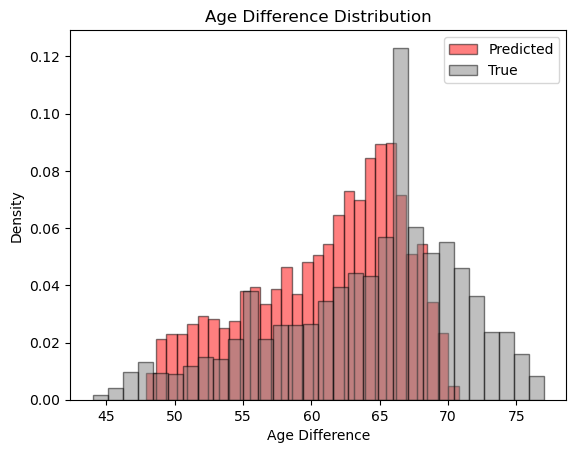

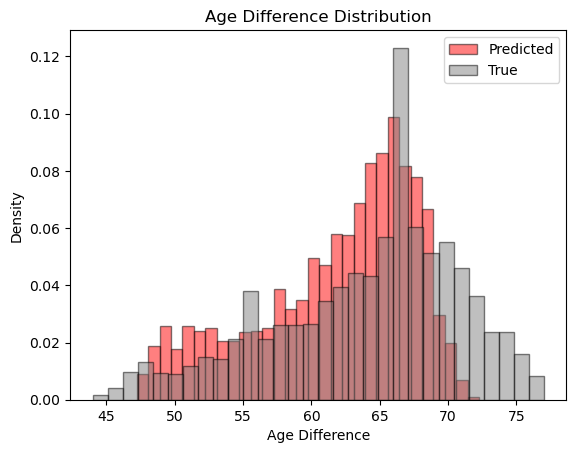

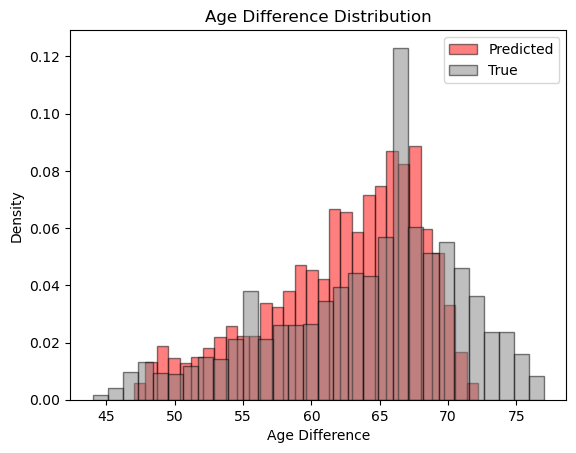

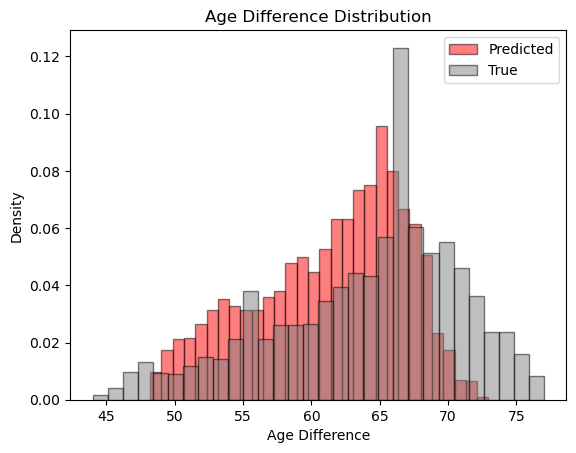

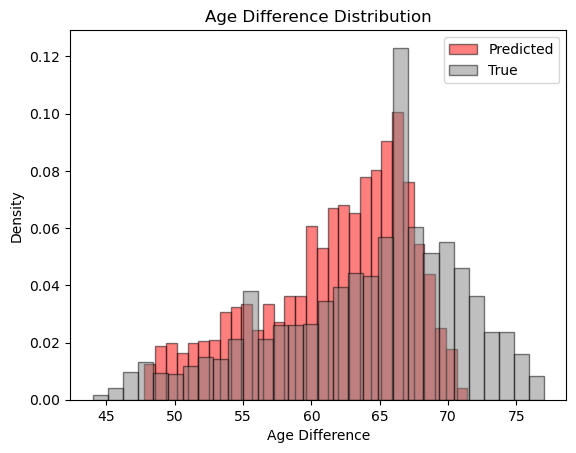

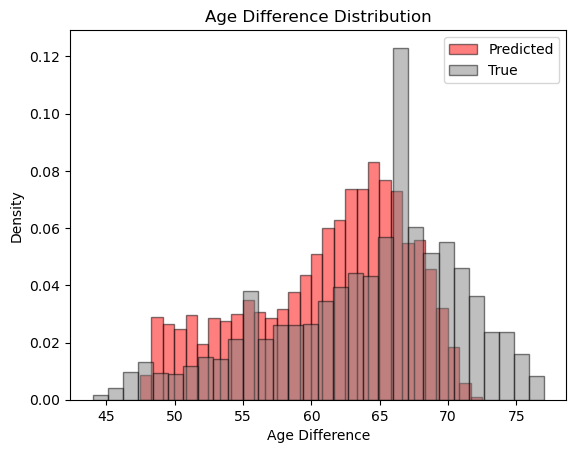

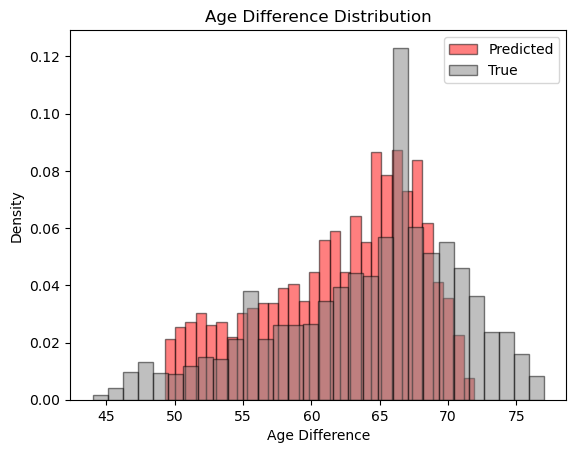

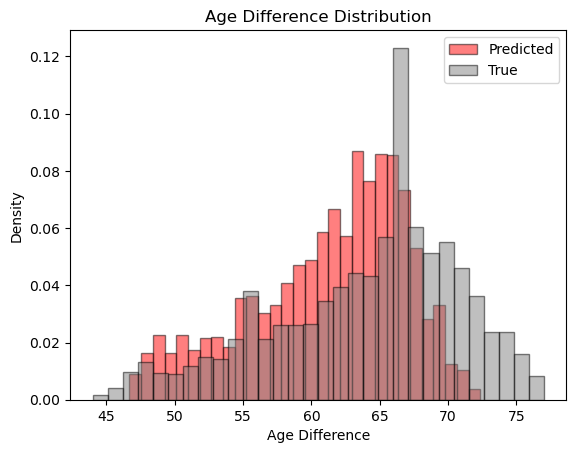

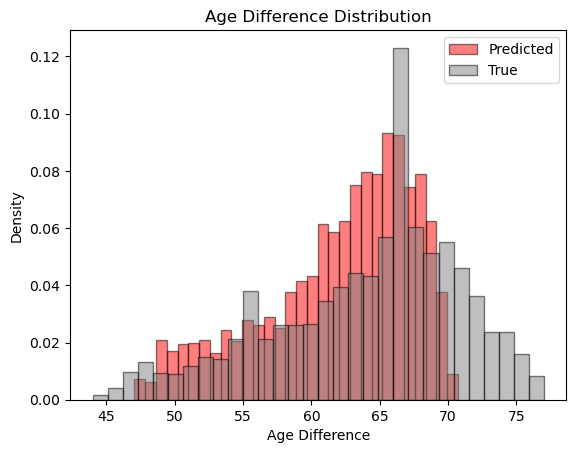

In [29]:
for key, region in regions.items():
    calculate_age_diff_dist(disease_ages,region)